In [1]:
from wedgescan_functions import get_slice_processed
from cil.framework import ImageGeometry
from cil.utilities.display import show2D
from cil.processors import RingRemover, Padder, Slicer
from cil.recon import FBP

import numpy as np

import matplotlib.pyplot as plt
from cil.plugins.tigre import ProjectionOperator

In [2]:
data_slice = get_slice_processed(400)

/mnt/data/ESRF/Wedgescan_Iterative_ASSB/flats.h5
	 - data : <HDF5 dataset "data": shape (60, 2160, 2560), type "<i4">
			 - interpretation : image
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/darks.h5
	 - data : <HDF5 dataset "data": shape (20, 2160, 2560), type "<i4">
			 - interpretation : image
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0000.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0001.h5


/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0002.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0003.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0004.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0005.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0006.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0007.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0008.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0009.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0010.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0011.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0012.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0013.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0014.h5
Running transmission-absorption converter
Running gradient correction
Running phase retrieval


In [3]:
# crop empty projections
data_crop = Slicer(roi={'angle': (300, 2710, 1)})(data_slice)
# process cropped data
ig = data_crop.geometry.get_ImageGeometry()
r = RingRemover(8,'db20', 1.5)
r.set_input(data_crop)
data_crop = r.get_output()
data_crop.geometry.set_centre_of_rotation(16.5, distance_units='pixels')

Finish Ring Remover


In [4]:
padsize = 3000
data_pad = Padder.linear_ramp(padsize, 0)(data_crop)


#### Try filtering data in place then back projection 

FBP recon

Input Data:
	angle: 2410
	horizontal: 8560

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 15
	Filter_inplace: True
	Split processing: 0

Reconstructing in 1 chunk(s):



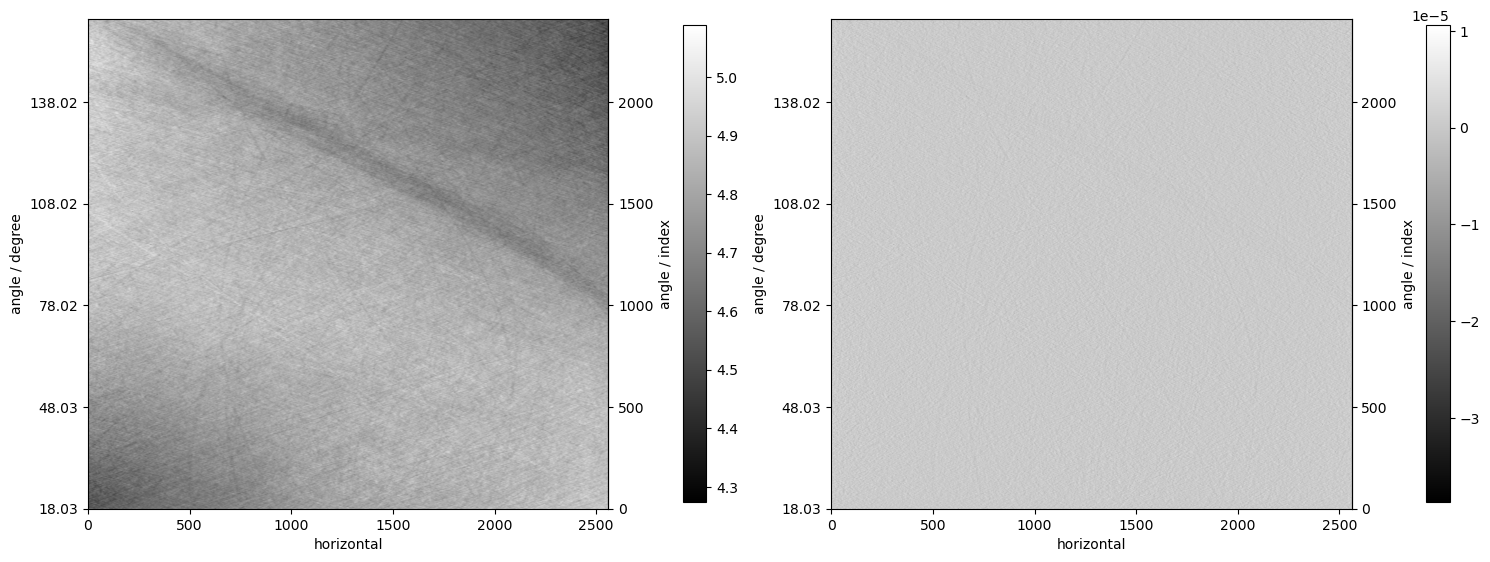

In [5]:
data_filter = data_pad.copy()

fbp = FBP(data_filter, ig)
fbp.set_filter_inplace(True)
fbp.run()

roi = {'horizontal':(padsize, data_filter.shape[1]-padsize, 1)}
processor = Slicer(roi)
processor.set_input(data_filter)
data_filter = processor.get_output()

show2D([data_crop, data_filter])

FBP recon

Input Data:
	angle: 2410
	horizontal: 8560

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 15
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



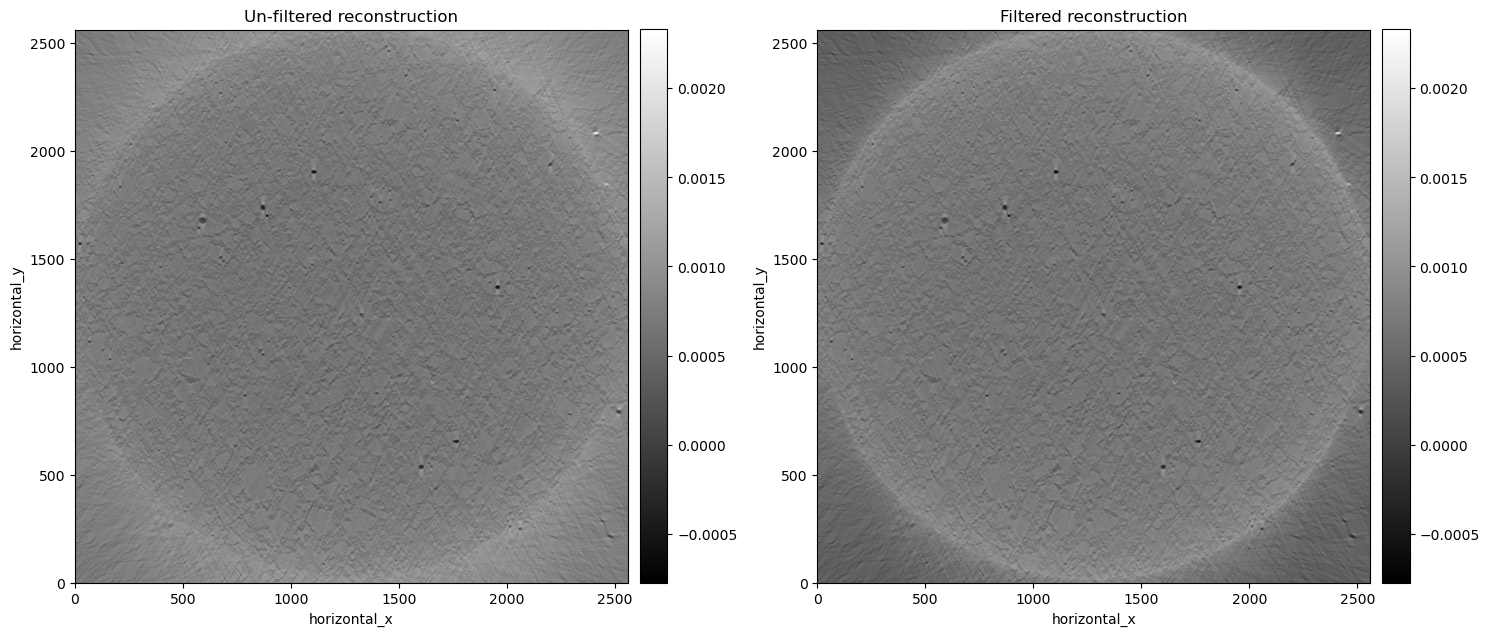

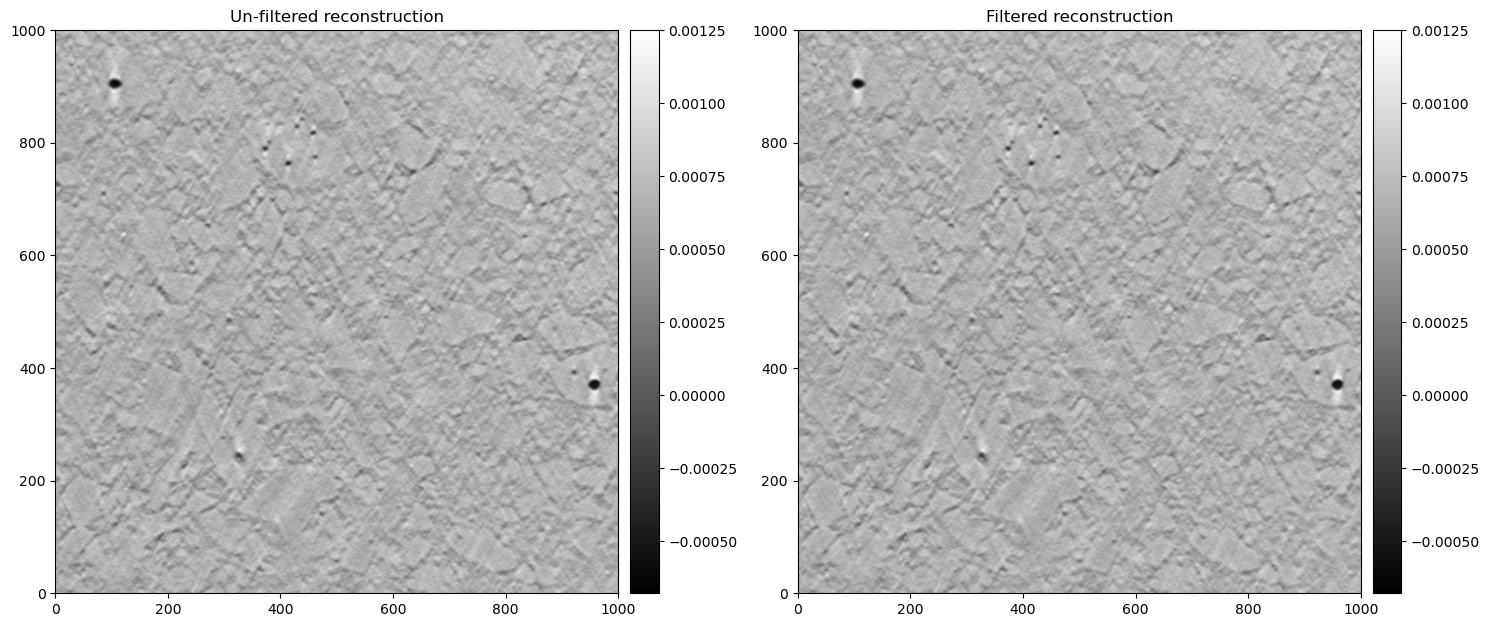

In [6]:
reco = FBP(data_pad, ig).run()
projection_operator = ProjectionOperator(image_geometry=None, acquisition_geometry=data_filter.geometry,adjoint_weights='FDK')
reco_filter = projection_operator.adjoint(data_filter)
# reco_filter.apply_circular_mask(0.9)

show2D([reco, reco_filter], ['Un-filtered reconstruction', 'Filtered reconstruction'], fix_range = True)
show2D([reco.array[1000:2000,1000:2000],reco_filter.array[1000:2000,1000:2000]], ['Un-filtered reconstruction', 'Filtered reconstruction'], fix_range = True)

#### Try subtracting the background in the ROI caused by the outer volume
- Back project filtered data onto large volume
- Set central ROI to zero
- Forward project
- Subtract from the data

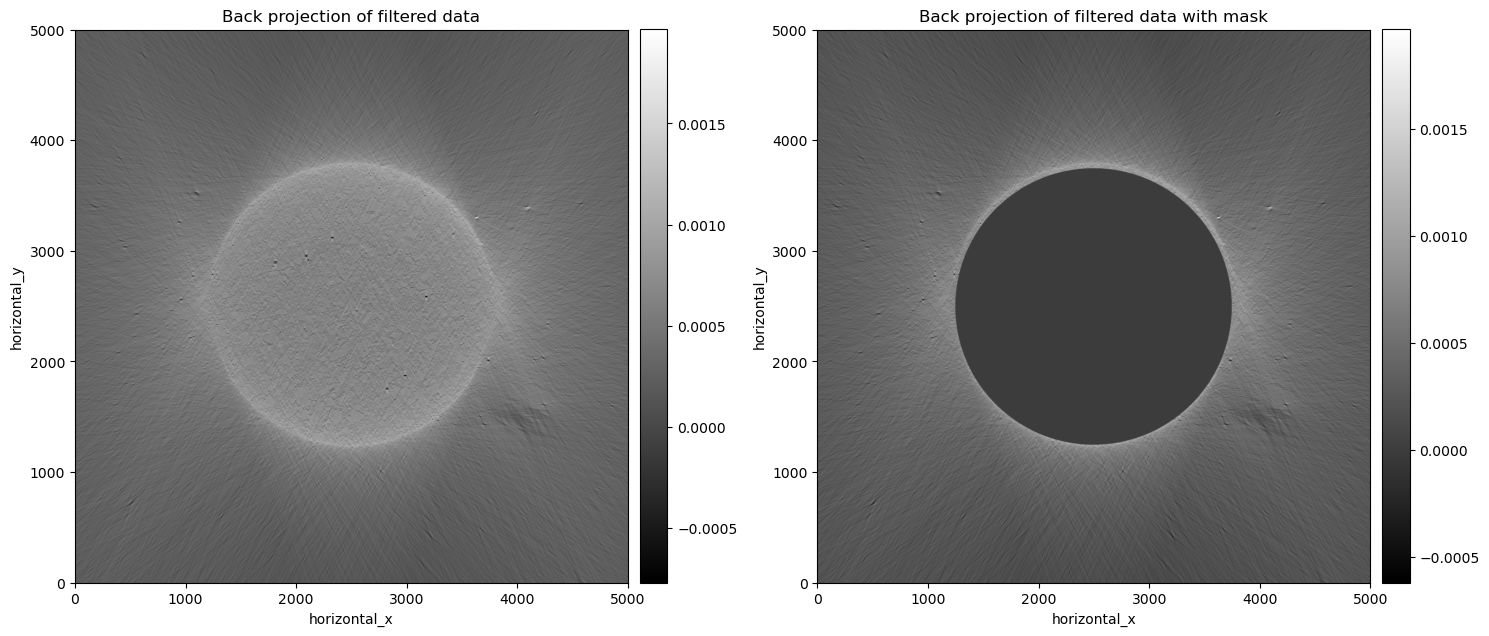

In [7]:
projection_operator = ProjectionOperator(image_geometry=ImageGeometry(5000,5000), acquisition_geometry=data_filter.geometry,adjoint_weights='FDK')
reco_backprojected = projection_operator.adjoint(data_filter)

reco_backprojected_crop = reco_backprojected.copy()
mask = (np.arange(reco_backprojected_crop.shape[0])[np.newaxis,:]-2500)**2 + (np.arange(reco_backprojected_crop.shape[0])[:,np.newaxis]-2500)**2 < (2500/2)**2
reco_backprojected_crop.array[mask] = 0

show2D([reco_backprojected, reco_backprojected_crop], ['Back projection of filtered data', 'Back projection of filtered data with mask'])

In [8]:
forward_projection = projection_operator.direct(reco_backprojected_crop)

projection_operator_full = ProjectionOperator(image_geometry=ig, acquisition_geometry=data_crop.geometry, adjoint_weights='FDK')
forward_projection_full = projection_operator.direct(reco_backprojected_crop)

subtracted = data_crop - forward_projection


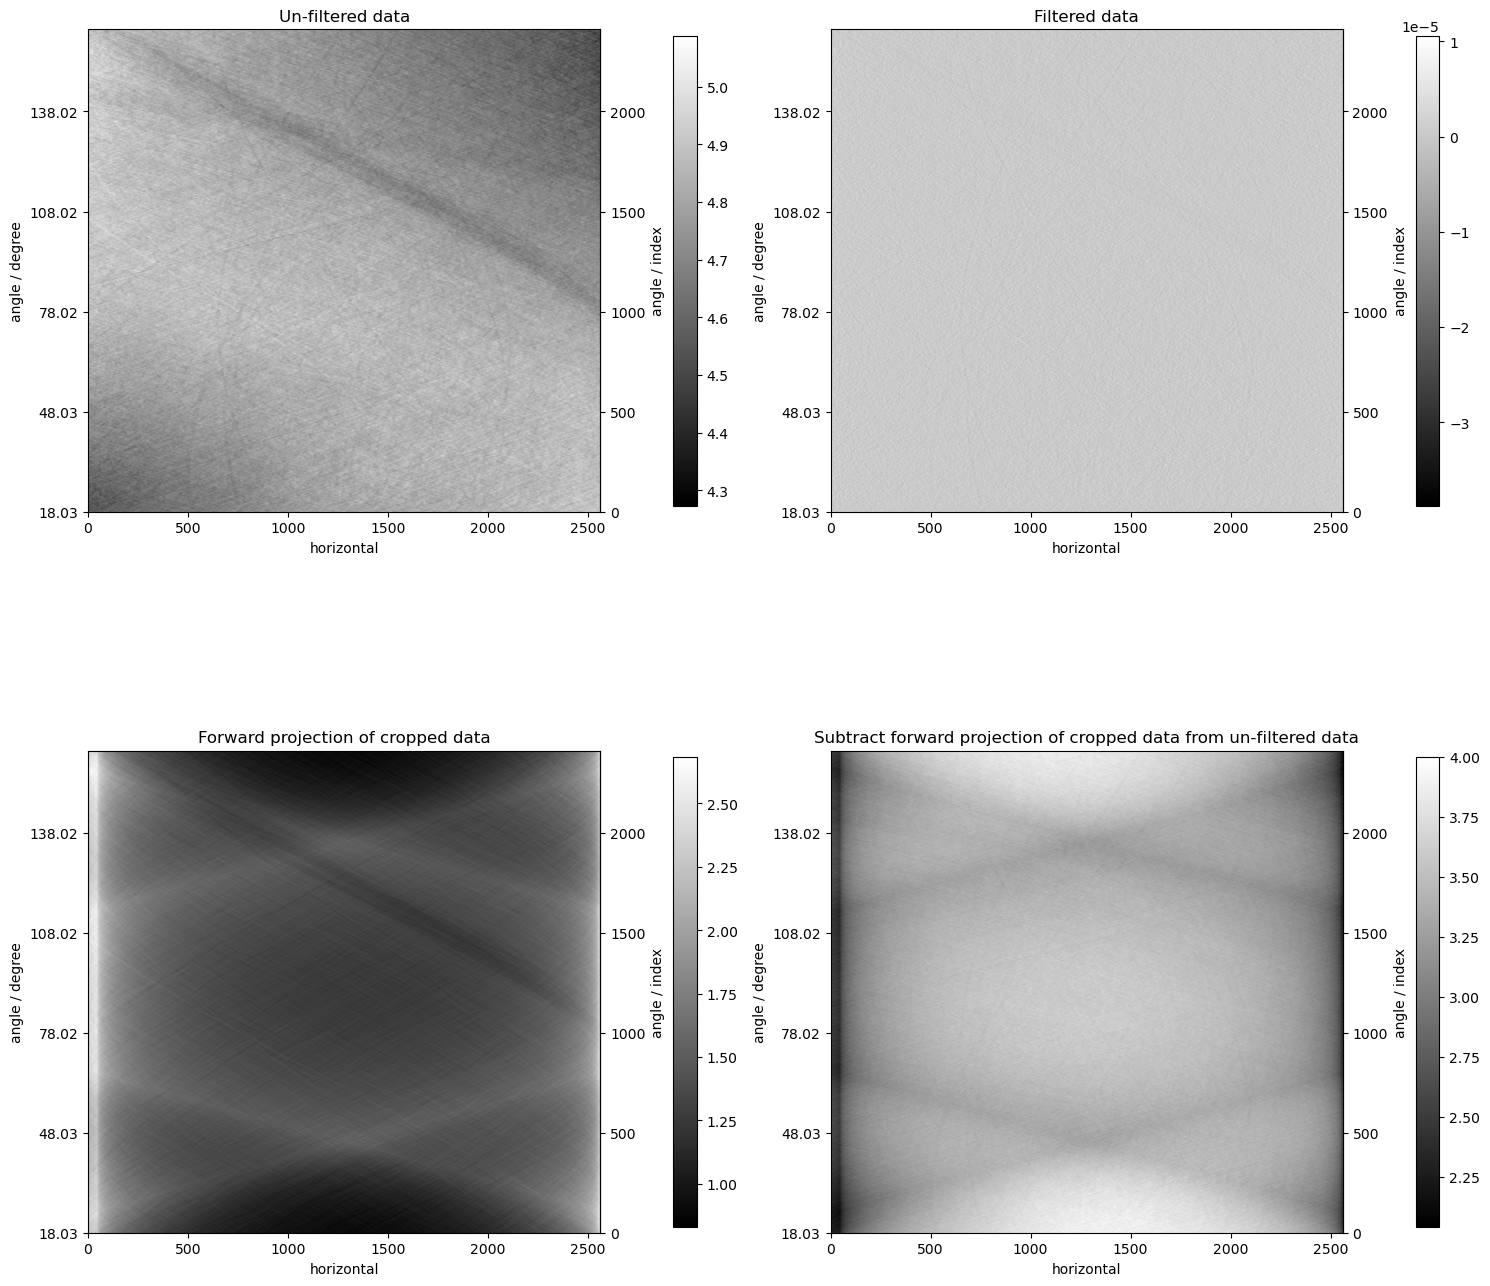

In [9]:
show2D([data_crop, data_filter, forward_projection, subtracted], ['Un-filtered data', 'Filtered data', 'Forward projection of cropped data', 'Subtract forward projection of cropped data from un-filtered data'])

In [10]:
reco_subtracted = FBP(subtracted).run()

FBP recon

Input Data:
	angle: 2410
	horizontal: 2560

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



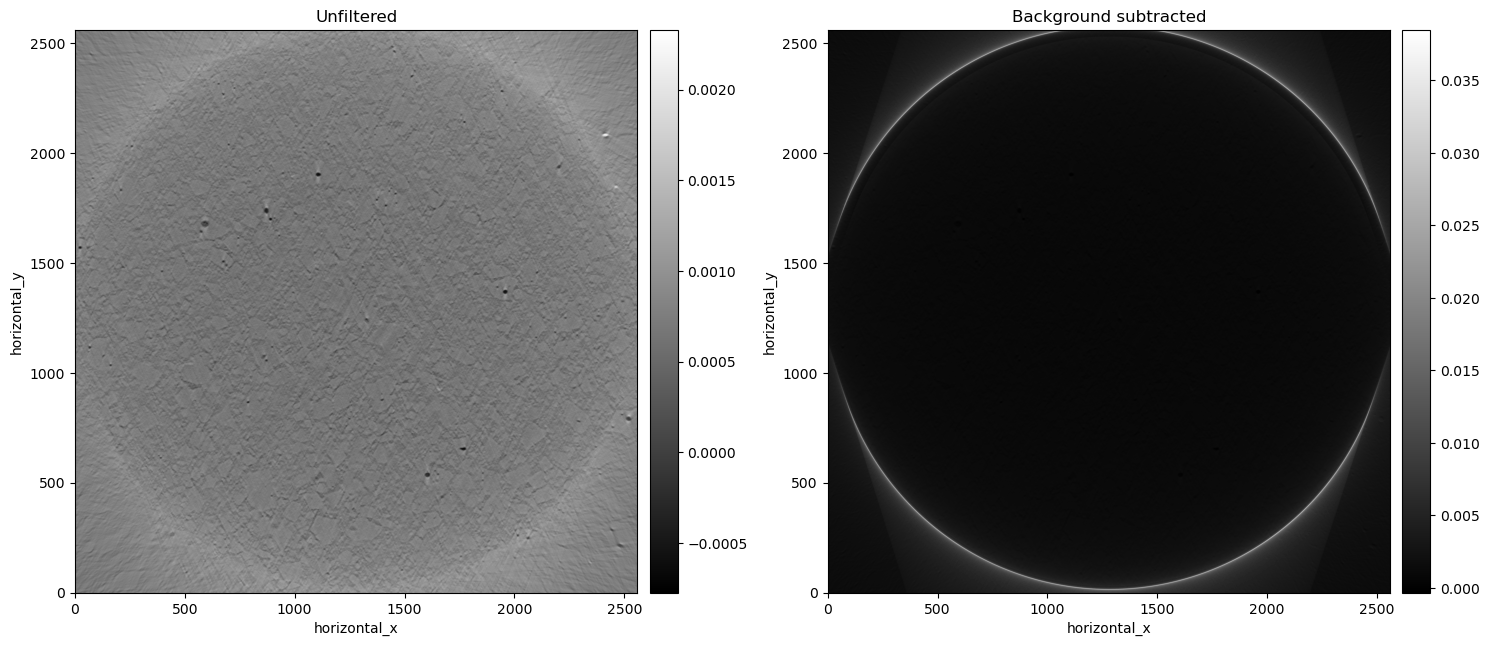

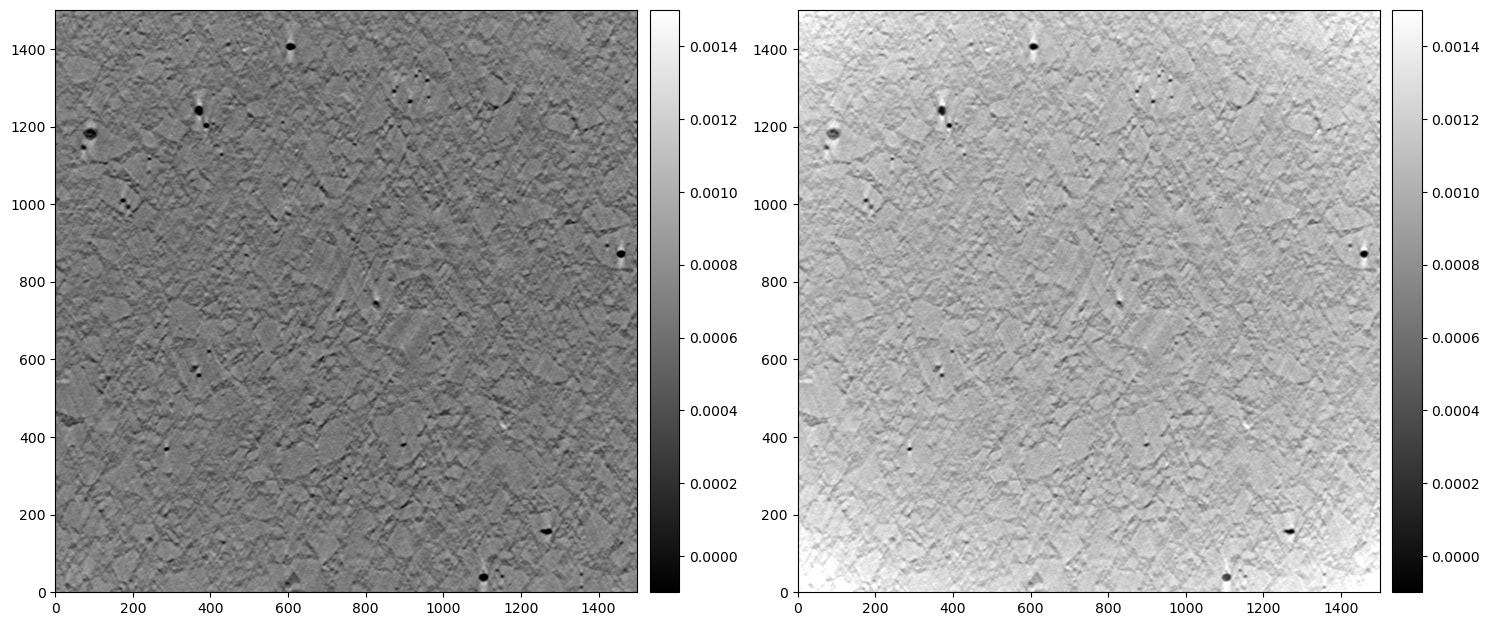

In [11]:
show2D([reco, reco_subtracted], ['Unfiltered', 'Background subtracted'])
show2D([reco.array[500:2000, 500:2000], reco_subtracted.array[500:2000, 500:2000]], fix_range=(-0.0001,0.0015))

FBP recon

Input Data:
	angle: 2410
	horizontal: 4560

Reconstruction Volume:
	horizontal_y: 4560
	horizontal_x: 4560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 14
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



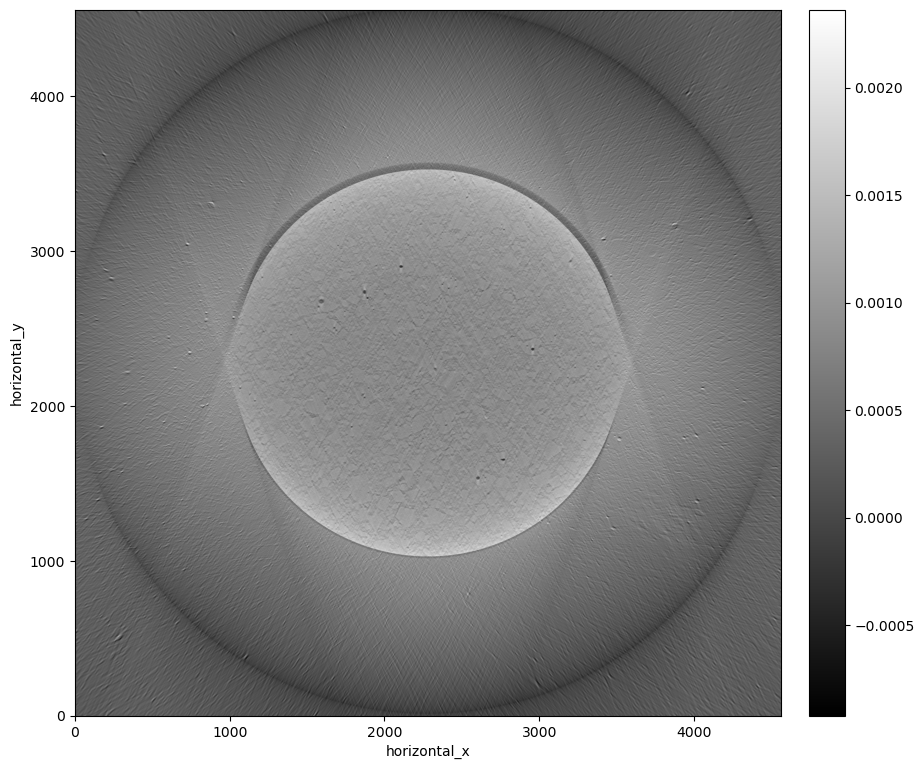

In [12]:
padsize = 1000
subtracted_pad = Padder.linear_ramp(padsize, 0)(subtracted)

reco_subtracted = FBP(subtracted_pad).run()
show2D(reco_subtracted)

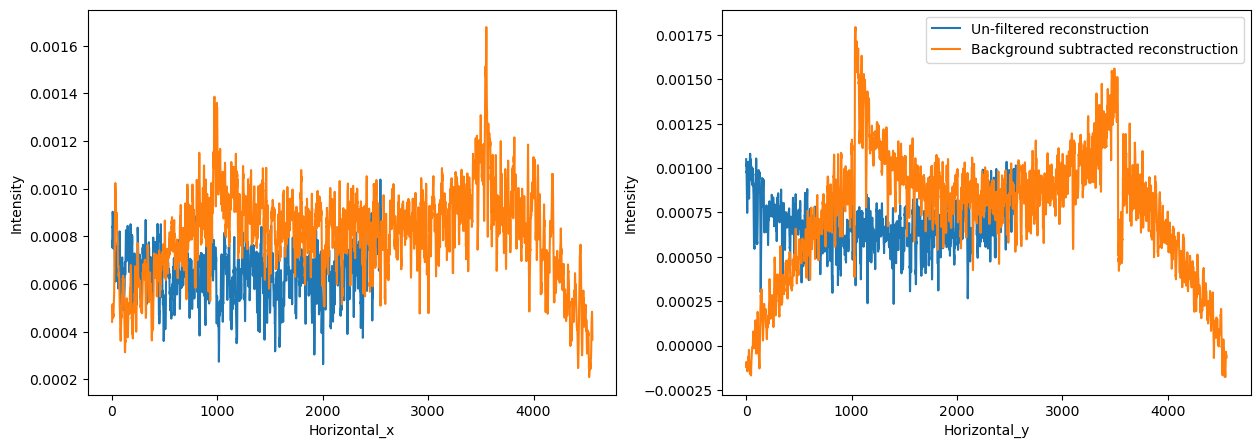

In [13]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
ax = axs[0]
ax.plot(reco.array[int(reco.shape[0]/2),:])
ax.plot(reco_subtracted.array[int(reco_subtracted.shape[0]/2),:])
ax.set_xlabel('Horizontal_x')
ax.set_ylabel('Intensity')

ax = axs[1]
ax.plot(reco.array[:,int(reco.shape[1]/2)])
ax.plot(reco_subtracted.array[:,int(reco_subtracted.shape[1]/2)])
ax.set_xlabel('Horizontal_y')
ax.set_ylabel('Intensity')

ax.legend(['Un-filtered reconstruction', 'Background subtracted reconstruction'])


Text(0.5, 0, 'Intensity')

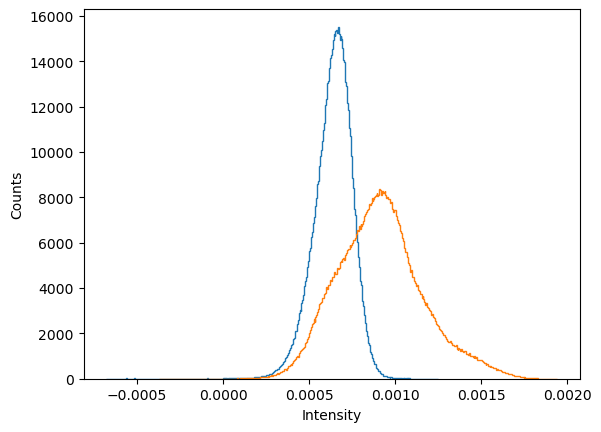

In [14]:

counts, bins = np.histogram(reco.array[1000:2000,1000:2000], bins=500)
plt.stairs(counts, bins)
counts, bins = np.histogram(reco_subtracted.array[1000:2000,1000:2000], bins=500)
plt.stairs(counts, bins)
ax.legend(['Un-filtered reconstruction', 'Background subtracted reconstruction'])
plt.ylabel('Counts')
plt.xlabel('Intensity')
